<a href="https://colab.research.google.com/github/Hareg2024/User-churn/blob/main/waze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to bigquery

In [2]:
#import libraries
from google.cloud import bigquery
from google.colab import auth

#authonticate
auth.authenticate_user()

#Initialize the client from bigquery
PROJECT_id = 'userchurn-431116'
client =bigquery.Client(project= PROJECT_id, location='US')


In [3]:
#get the dataset and table , one table at a time
dataset_ref = client.dataset('wazedata', project='userchurn-431116')
table_ref = dataset_ref.table('rawdata')
table = client.get_table(table_ref)
table.schema

[SchemaField('ID', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('label', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('sessions', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('drives', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('total_sessions', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('n_days_after_onboarding', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('total_navigations_fav1', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('total_navigations_fav2', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('driven_km_drives', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('duration_minutes_drives', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('activity_days', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('driving_days', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('device', 'STRING', 'NULLABLE', None, None, (), None)]

In [4]:
# bring the second table for the test table
table_ref = dataset_ref.table('testdata')
testtable = client.get_table(table_ref)
testtable.schema

[SchemaField('ID', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('label', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('sessions', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('drives', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('total_sessions', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('n_days_after_onboarding', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('total_navigations_fav1', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('total_navigations_fav2', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('driven_km_drives', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('duration_minutes_drives', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('activity_days', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('driving_days', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('device', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('typ

In [5]:
# convert the 2 tables into dataframe
df = client.list_rows(table=table).to_dataframe()
df.head()


,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,1806,retained,0,0,37.168690,3098,236,0,5570.745476,943.950161,6,0,Android
1,3451,retained,0,0,210.090088,2873,210,35,12012.320180,4804.667454,1,0,Android
2,6375,retained,0,0,99.767601,1386,21,0,4169.721686,3154.856024,2,0,Android
3,8122,retained,0,0,132.322350,89,174,104,5044.893956,2205.094060,4,0,iPhone
4,10586,churned,0,0,222.107433,980,0,6,4932.029466,2656.000047,3,0,Android


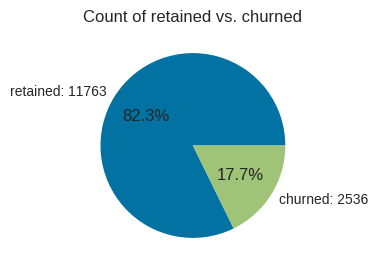

In [15]:
# Pie chart
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3,3))
data=df['label'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Count of retained vs. churned');

* Less than 18% of users churned, and ~82% were retained.

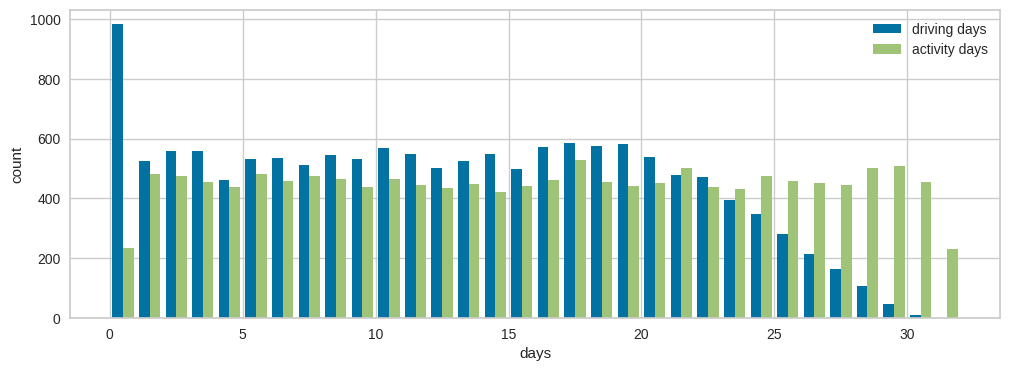

In [16]:
# Histogram
plt.figure(figsize=(12,4))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()

After all, why are there fewer people who didn't use the app at all during the month and more people who didn't drive at all during the month?

On the other hand, it could just be illustrative of the fact that, while these variables are related to each other, they're not the same. People probably just open the app more than they use the app to drive—perhaps to check drive times or route information, to update settings, or even just by mistake.

Nonetheless, it might be worthwile to contact the data team at Waze to get more information about this, especially because it seems that the number of days in the month is not the same between variables.

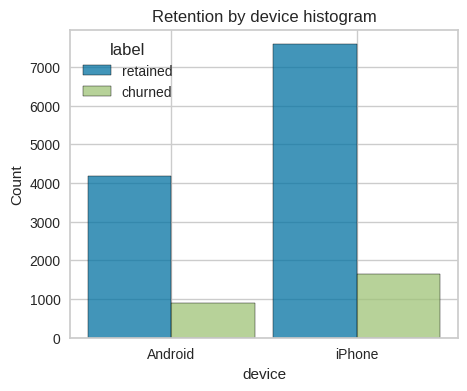

In [18]:
# check if the device has impact on the churn rate
import seaborn as sns
plt.figure(figsize=(5,4))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Retention by device histogram');

* Iphone users are relatively higher in number and most of them are retained

## Feature Engineering

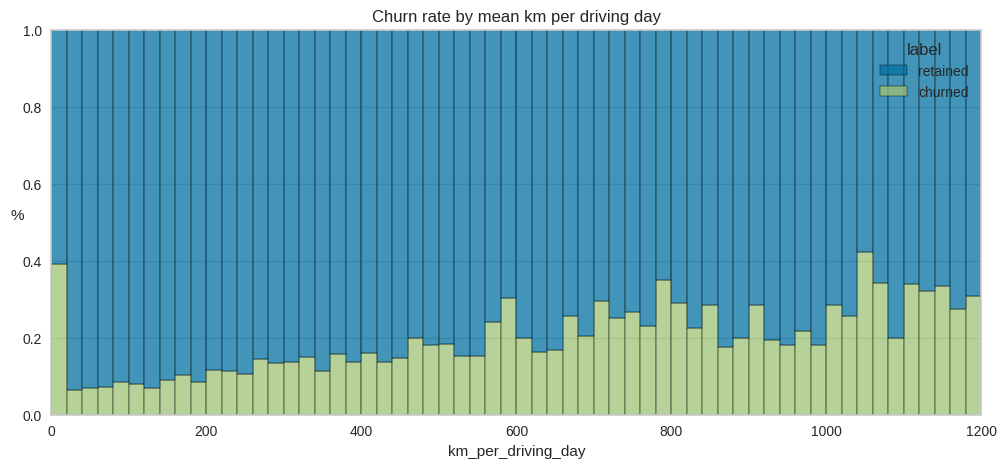

In [31]:
# Analysing impact of driving days on user churn
import numpy as np
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='km_per_driving_day',
             bins=range(0,1201,20),
             hue='label',
             multiple='fill')
plt.ylabel('%', rotation=0)
plt.title('Churn rate by mean km per driving day');

* Distance driven per driving day had a positive correlation with user churn. The farther a user drove on each driving day, the more likely they were to churn. On the other hand, number of driving days had a negative correlation with churn. Users who drove more days of the last month were less likely to churn.

In [38]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

# 2. Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

* The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

## Handling outlier

In [42]:
def outlier_imputer(column_name, percentile):
    # Calculate threshold
    threshold = df[column_name].quantile(percentile)
    # Impute threshold for values > than threshold
    df.loc[df[column_name] > threshold, column_name] = threshold

    print('{:>25} | percentile: {} | threshold: {}'.format(column_name, percentile, threshold))

In [43]:
#impute outliers that are  greater 95% percetiles with threshold (95%)
for column in ['sessions', 'drives', 'total_sessions',
               'driven_km_drives', 'duration_minutes_drives']:
               outlier_imputer(column, 0.95)

                 sessions | percentile: 0.95 | threshold: 243.0
                   drives | percentile: 0.95 | threshold: 200.0
           total_sessions | percentile: 0.95 | threshold: 455.42709530949
         driven_km_drives | percentile: 0.95 | threshold: 8898.673053265
  duration_minutes_drives | percentile: 0.95 | threshold: 4668.1098283338


## Test data

In [6]:
# the second table is a view table and cannot be directly converted to dataframe , we are gonna query the view table
sql = """
SELECT *
FROM `userchurn-431116.wazedata.testdata`
"""

query_job = client.query(sql)
results = query_job.result()  # Waits for the query to finish
df_test = results.to_dataframe()
df_test.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,type
0,1806,retained,0,0,37.168690,3098,236,0,5570.745476,943.950161,6,0,Android,test
1,3451,retained,0,0,210.090088,2873,210,35,12012.320180,4804.667454,1,0,Android,test
2,6375,retained,0,0,99.767601,1386,21,0,4169.721686,3154.856024,2,0,Android,test
3,8122,retained,0,0,132.322350,89,174,104,5044.893956,2205.094060,4,0,iPhone,test
4,10586,churned,0,0,222.107433,980,0,6,4932.029466,2656.000047,3,0,Android,test


# Build Model

## Install pycaret to access auto ml

In [9]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━

# Code and Train

In [10]:
#get the classification model: user chaurn is catagorical y
from pycaret.classification  import *

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14299 non-null  Int64  
 1   label                    14299 non-null  object 
 2   sessions                 14299 non-null  Int64  
 3   drives                   14299 non-null  Int64  
 4   total_sessions           14299 non-null  float64
 5   n_days_after_onboarding  14299 non-null  Int64  
 6   total_navigations_fav1   14299 non-null  Int64  
 7   total_navigations_fav2   14299 non-null  Int64  
 8   driven_km_drives         14299 non-null  float64
 9   duration_minutes_drives  14299 non-null  float64
 10  activity_days            14299 non-null  Int64  
 11  driving_days             14299 non-null  Int64  
 12  device                   14299 non-null  object 
 13  km_per_driving_day       14299 non-null  Float64
 14  professional_driver      14

In [45]:
#handle missing values and duplicates
df=df.dropna(axis=0)

#df=-df.drop_duplicates()

df.duplicated().sum()

0

In [46]:
# setup model
setup(data=df,
      target='label',
      session_id=123,
      ignore_features=['ID','type'],
      categorical_features=['device'])

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Binary
3,Target mapping,"churned: 0, retained: 1"
4,Original data shape,"(14299, 15)"
5,Transformed data shape,"(14299, 14)"
6,Transformed train set shape,"(10009, 14)"
7,Transformed test set shape,"(4290, 14)"
8,Ignore features,2
9,Numeric features,12


In [36]:
#compare all classification model with sklearn models based on evaluation metrics
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8241,0.7573,0.8241,0.7771,0.7681,0.1028,0.1556,1.4690
ada,Ada Boost Classifier,0.8238,0.7413,0.8238,0.7789,0.7759,0.1376,0.1824,0.8650
ridge,Ridge Classifier,0.8231,0.7571,0.8231,0.7747,0.7462,0.0137,0.0545,0.1330
gbc,Gradient Boosting Classifier,0.8230,0.7466,0.8230,0.7769,0.7706,0.1146,0.1639,2.9590
dummy,Dummy Classifier,0.8227,0.5000,0.8227,0.6768,0.7426,0.0000,0.0000,0.1240
rf,Random Forest Classifier,0.8226,0.7237,0.8226,0.7776,0.7755,0.1364,0.1799,2.4380
lda,Linear Discriminant Analysis,0.8223,0.7571,0.8223,0.7729,0.7681,0.1037,0.1513,0.1340
et,Extra Trees Classifier,0.8219,0.7227,0.8219,0.7766,0.7746,0.1330,0.1764,1.3590
lightgbm,Light Gradient Boosting Machine,0.8203,0.7298,0.8203,0.7745,0.7760,0.1409,0.1786,3.0730
xgboost,Extreme Gradient Boosting,0.8113,0.7047,0.8113,0.7678,0.7772,0.1578,0.1794,0.4200


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### The GradientBoosting model is selected based on evaluation metrics,
* Accuracy= 0.82,Recall(how many of the actual positives were correctly identified)=0.82  and
* Precission (the accuracy of positive predictions)=0.78

In [47]:
# use the best model
gbst = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8342,0.7567,0.8342,0.8081,0.7852,0.1684,0.2396
1,0.8272,0.7328,0.8272,0.7880,0.7816,0.1579,0.2072
2,0.8312,0.7732,0.8312,0.8012,0.7781,0.1395,0.2103
3,0.8172,0.7329,0.8172,0.7587,0.7639,0.0862,0.1214
4,0.8202,0.7505,0.8202,0.7663,0.7636,0.0878,0.1328
5,0.8092,0.7466,0.8092,0.7306,0.7499,0.0352,0.0526
6,0.8212,0.7506,0.8212,0.7729,0.7709,0.1188,0.1629
7,0.8122,0.6993,0.8122,0.7540,0.7638,0.0946,0.1225
8,0.8302,0.7614,0.8302,0.7985,0.7793,0.1496,0.2157


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [48]:
# use the model to predict on holdout data
gbst_pred = predict_model(gbst)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8242,0.7379,0.8242,0.7797,0.7719,0.1190,0.1708


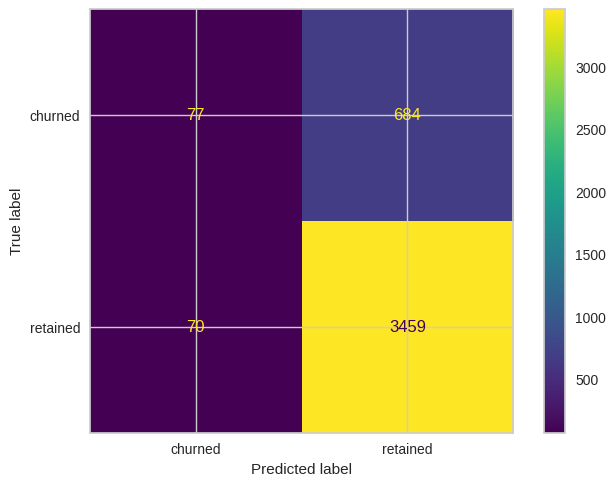

In [57]:
#confusion matrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix( gbst_pred['prediction_label'],gbst_pred['label'])
ConfusionMatrixDisplay.from_predictions(gbst_pred['label'], gbst_pred['prediction_label'])


* The model has mediocre precision and very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

In [58]:
df_final=gbst_pred.copy()
df_final.head(5)

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver,label,prediction_label,prediction_score
1487,126,110,164.833176,2486,432,0,2159.167725,501.427673,6,1,iPhone,2159.167649,0,churned,retained,0.8535
6682,9,9,440.216736,1638,139,32,1877.869507,1016.116577,18,11,iPhone,170.715405,0,retained,retained,0.9235
7663,155,127,286.282410,782,721,4,6827.522949,3161.975342,12,12,Android,568.960255,0,churned,churned,0.5900
12677,68,55,119.666885,957,34,25,1369.640503,402.879852,27,21,Android,65.220976,0,retained,retained,0.9557
3436,34,28,136.838440,841,393,10,3064.986328,2048.386719,9,5,iPhone,612.997282,0,retained,retained,0.5689


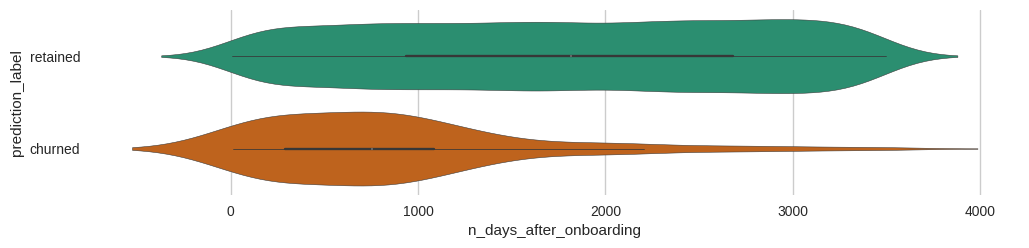

In [78]:
# @title prediction_label vs n_days_after_onboarding

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_final['prediction_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_final, x='n_days_after_onboarding', y='prediction_label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

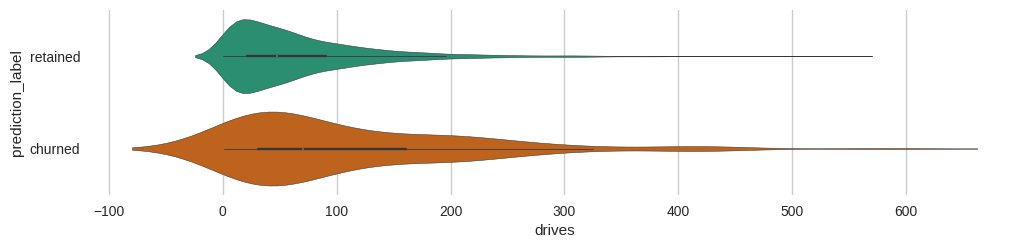

In [77]:
# @title prediction_label vs drives

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_final['prediction_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_final, x='drives', y='prediction_label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [59]:
churned= df_final['label']
churned.value_counts()


,count
label,
retained,3529
churned,761


In [60]:
churned= df_final['prediction_label']
churned.value_counts()

,count
prediction_label,
retained,4143
churned,147


* The model predicts only 147 churn while it is actually 761 customer churn
* Applying feature engineering might improve the accuracy
* It is also due to feature imbalace , rescaling the data could help improve the accuracy

In [74]:
# Test the model using test data
df_test=df_test.dropna(axis=0)
test =predict_model(gbst, data=df_test)
test.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7010,0.6876,0.7010,0.6663,0.6408,0.1326,0.1704


,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,type,label,prediction_label,prediction_score
0,1806,0,0,37.168690,3098,236,0,5570.745605,943.950134,6,0,Android,test,retained,retained,0.8072
1,3451,0,0,210.090088,2873,210,35,12012.320312,4804.667480,1,0,Android,test,retained,retained,0.7543
2,6375,0,0,99.767601,1386,21,0,4169.721680,3154.855957,2,0,Android,test,retained,retained,0.5627
3,8122,0,0,132.322357,89,174,104,5044.894043,2205.093994,4,0,iPhone,test,retained,retained,0.5533
4,10586,0,0,222.107437,980,0,6,4932.029297,2656.000000,3,0,Android,test,churned,retained,0.5184


In [72]:
#actual
churned= test['label']
churned.value_counts()

,count
label,
retained,67
churned,30


In [75]:
# model output
churned= test['prediction_label']
churned.value_counts()

,count
prediction_label,
retained,88
churned,9


In [76]:
# save the current model output data to bigquery
test.to_gbq(destination_table='wazedata.testoutput', project_id='userchurn-431116', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 606.81it/s]


# Model Optimization